# 数据建模  
数据建模在机器学习中具有极其重要的地位。它是机器学习的核心组成部分，对于训练和评估模型、做出预测和优化决策都至关重要。

模型训练和学习：在机器学习中，模型通过从数据中学习模式和关系来进行训练。模型的性能和准确性取决于所用数据的质量和数量。良好的数据建模可以提供高质量的训练数据，有助于构建更准确和可靠的模型。

## 分类数据建模

机器学习的一般框架：
训练集 => 提取特征向量 => 结合一定的算法（分类器：比如决策树、KNN）=>得到结果

支持向量机（support vector machines，SVM）是一种二分类模型，它将实例的特征向量映射为空间中的一些点，SVM 的目的就是想要画出一条线，以 “最好地” 区分这两类点，以至如果以后有了新的点，这条线也能做出很好的分类。SVM 适合中小型数据样本、非线性、高维的分类问题。

SVM 是有监督的学习模型，就是说我们需要先对数据打上标签，之后通过求解最大分类间隔来求解二分类问题，而对于多分类问题，可以组合多个 SVM 分类器来处理。
### SVM 基本概念  
将实例的特征向量（以二维为例）映射为空间中的一些点，如下图的实心点和空心点，它们属于不同的两类。SVM 的目的就是想要画出一条线，以“最好地”区分这两类点，以至如果以后有了新的点，这条线也能做出很好的分类。

![image](https://github.com/X-lab2017/OpenTEA101/assets/115639837/f85c6a50-aca5-44d9-85e0-d1a6b4b57280)

其实在工具 sklearn 中，已经封装了多种 SVM 模型，这里我们重点介绍下 SVC，该模型既可以训练线性可分的数据，也可以训练线性不可分数据。

![image](https://github.com/X-lab2017/OpenTEA101/assets/115639837/36c6bc6f-7050-4588-b2a1-24faed758817)


## GitHub机器人检测

在开始之前，确保已经安装了Python，并且安装相应的两个库。可以通过 pip install pandas 和 pip install scikit-learn 来安装。
完成以上步骤后，Pandas 和 Scikit-Learn 将安装在你的 Python 环境中，你可以在代码中导入它们并开始使用它们。例如：


In [42]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

数据探索

我们先来加载数据，查看下数据情况

In [43]:
df = pd.read_csv('./data/github_bot_processed_data.csv')

In [44]:
df = pd.read_csv('./data/github_bot_processed_data.csv')
df['label'] = df['label'].apply(lambda x: 1 if x =='Human' else 0)
print(df.head())

   label  type  site_admin  company   blog  location  hireable  public_repos  \
0      1  True       False    False  False     False     False            26   
1      1  True       False    False   True     False      True            30   
2      1  True       False     True   True      True      True           103   
3      0  True       False    False  False      True     False            49   
4      1  True       False    False  False     False      True            11   

   public_gists  followers  following                 created_at  \
0             1          5          1  2011-09-26 17:27:03+00:00   
1             3          9          6  2015-06-29 10:12:46+00:00   
2            49       1212        221  2008-08-29 16:20:03+00:00   
3             0         84          2  2014-05-20 18:43:09+00:00   
4             1          6          2  2012-08-16 14:19:13+00:00   

                  updated_at  text_bot_count  
0  2023-10-13 11:21:10+00:00               0  
1  2023-10-07 06

数据集的字段含义：

actor_id: GitHub用户的唯一标识符。  
public_repos: 用户的公共仓库数量。  
public_gists: 用户的公共代码片段数量。  
followers: 关注该用户的人数。  
following: 该用户关注的人数。  

我们要预测的标签就是字段 type，是一个二分类的问题。   
除去 id 和 type 字段，还有4个字段，它们都是用户特征。

In [45]:
num_label_0_samples = df[df['label'] == 0].shape[0]
label_1_samples = df[df['label'] == 1].sample(num_label_0_samples, random_state=42)
df = pd.concat([df[df['label'] == 0], label_1_samples], axis=0, ignore_index=True)
# df = pd.read_csv('./data/github_bot_model_data')

In [46]:
# 2. 划分数据集，80%用于训练，20%用于测试
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

数据预处理和模型训练介绍

在进行机器学习任务时，首要任务之一是准备和处理数据，以便将其用于训练和评估机器学习模型。这个过程包括选择适当的特征，将数据划分为训练集和测试集，进行数据标准化，并选择合适的模型来进行训练和预测。

1. 选择用于预测的特征列：

首先，我们需要选择哪些特征（或属性）将用于预测任务。在这个示例中，我们选择了以下特征列：'public_repos'，'public_gists'，'followers'，和 'following'。这些特征将用于训练模型来预测一个用户的 'type'，这个类型可能代表了用户在某个社交媒体或平台上的活跃程度等信息。

In [47]:
# 3. 选择用于预测的特征列
feature_columns = ['type', 'site_admin', 'company', 'blog', 'location', 'hireable', 'public_repos', 'public_gists', 'followers', 'following', 'text_bot_count']

2. 训练集和测试集的输入特征：

我们将数据分成两个部分：训练集和测试集。训练集将用于模型的训练，而测试集将用于评估模型的性能。我们需要从原始数据中提取输入特征并将其分配给相应的训练集（X_train）和测试集（X_test）。

In [48]:
# 4. 训练集的输入特征
X_train = train_df[feature_columns]

# 5. 测试集的输入特征
X_test = test_df[feature_columns]


3. 训练集和测试集的标签：

除了输入特征外，我们还需要确定目标标签，也就是我们要预测的内容。在这个例子中，我们的目标是用户的 'type'。我们将 'type' 列分配给训练集标签（y_train）和测试集标签（y_test）

In [49]:
# 6. 训练集的标签
y_train = train_df['label']

# 7. 测试集的标签
y_test = test_df['label']

4. 数据标准化：

在训练机器学习模型之前，通常需要对数据进行标准化处理，以确保不同特征的值具有相似的范围，以避免某些特征对模型的影响过大。我们使用标准化器（StandardScaler）来对输入特征进行标准化处理。

In [50]:
# 8. 数据标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


5. 创建一个SVM分类器：

在数据准备工作完成后，我们选择了一个支持向量机（SVM）分类器来进行模型训练。SVM是一种强大的监督学习算法，适用于分类问题。

In [51]:
# 9. 创建一个SVM分类器
clf = SVC(probability=True)

6. 使用网格搜索进行调参
param_grid_svm中包括了SVM模型中的三个超参数 'C'、'kernel' 和 'gamma' 的候选取值。
- 'C' 是正则化参数，控制了错误项的惩罚程度。[0.1, 1, 10] 表示了三个候选取值。

- 'kernel' 是核函数，可以是 'linear'（线性核）、'poly'（多项式核）和 'rbf'（径向基函数核）。

- 'gamma' 影响核函数的作用范围，取值可以是 'scale'（与特征数量相关）和 'auto'（与样本数量相关）。

这样就可以使用 GridSearchCV 或 RandomizedSearchCV 进行参数搜索和模型选择，尝试这些参数组合来找到最优的 SVM 模型。

In [52]:
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf'],
    'gamma': ['scale', 'auto']
}
grid_search_svm = GridSearchCV(clf, param_grid_svm, cv=3)
grid_search_svm.fit(X_train_scaled, y_train)
best_params_svm = grid_search_svm.best_params_
best_params_svm

{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}

7. 训练模型：

接下来，我们使用训练集的输入特征（X_train_scaled）和标签（y_train）来训练SVM模型。模型将学习如何根据输入特征来预测用户的 'type'。

8. 在测试集上进行预测：

最后，我们使用训练好的模型来对测试集的输入特征（X_test_scaled）进行预测，以评估模型的性能和准确性。

In [53]:
# 10. 训练模型
best_clf = grid_search_svm.best_estimator_
best_clf.fit(X_train_scaled, y_train)

# 11. 在测试集上进行预测
y_pred = best_clf.predict(X_test_scaled)


8. 评估模型性能

现在，我们已经训练了一个支持向量机（SVM）模型，并使用测试集进行了预测。评估模型性能是确定模型对于实际数据的预测能力的关键步骤。在这里，我们将使用准确度（accuracy）作为性能指标来评估模型的表现。

准确度（Accuracy）是一个用于分类问题的常见性能指标，它表示模型正确预测的样本占总样本数的比例。简而言之，它衡量了模型的整体预测精度。

接下来的代码将计算模型的准确度并输出结果：

In [55]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("SVM:")
print("Best Parameters:", best_params_svm)
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

SVM:
Best Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Accuracy: 0.7626050420168067
Confusion Matrix:
 [[128 112]
 [  1 235]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.53      0.69       240
           1       0.68      1.00      0.81       236

    accuracy                           0.76       476
   macro avg       0.83      0.76      0.75       476
weighted avg       0.84      0.76      0.75       476



以下的代码可视化了SVM对于网格搜索各个参数经过交叉验证之后的准确率。

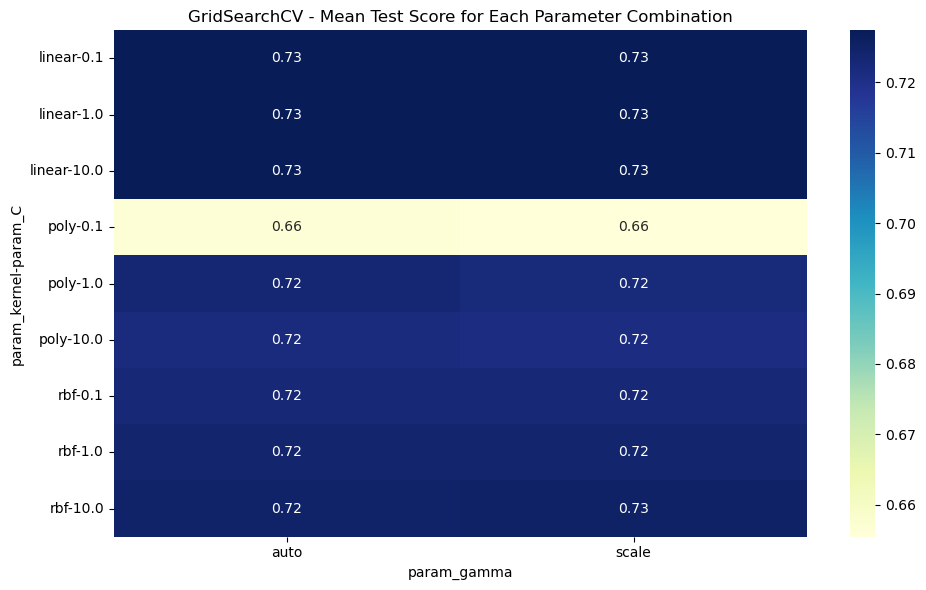

In [56]:
import seaborn as sns
cv_results = pd.DataFrame(grid_search_svm.cv_results_)[['param_C', 'param_kernel', 'param_gamma', 'mean_test_score']]
pivot_table = cv_results.pivot_table(index=['param_kernel', 'param_C'], columns='param_gamma', values='mean_test_score')

# 可视化参数网格搜索过程
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu', cbar=True)
plt.title('GridSearchCV - Mean Test Score for Each Parameter Combination')
plt.tight_layout()
plt.show()

## 使用其他常用分类算法

In [60]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.neighbors import KNeighborsClassifier

# 1. Load the dataset
# 2. Split the dataset into 80% training and 20% testing
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# 3. Select the feature columns for prediction
feature_columns = ['type', 'site_admin', 'company', 'blog', 'location', 'hireable', 'public_repos', 'public_gists', 'followers', 'following', 'text_bot_count']


# 4. Training set input features
X_train = train_df[feature_columns]

# 5. Testing set input features
X_test = test_df[feature_columns]

# 6. Training set labels
y_train = train_df['label']

# 7. Testing set labels
y_test = test_df['label']

# 8. Data Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the train and test data to files
joblib.dump(X_train_scaled, './data/X_train.joblib')
joblib.dump(X_test_scaled, './data/X_test.joblib')
joblib.dump(y_train, './data/y_train.joblib')
joblib.dump(y_test, './data/y_test.joblib')

# Create a list of classifiers to compare
classifiers = [
    ('Support Vector Machine', SVC(probability=True)),
    ('Logistic Regression', LogisticRegression()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('Naive Bayes', GaussianNB()),
    ('K-Nearest Neighbors', KNeighborsClassifier())
]

accuracy_values = []
f1_values = []
recall_values = []
precision_values = []
roc_curves = []
report_dict_list = []

# Train and evaluate each classifier
for name, clf in classifiers:
    clf.fit(X_train_scaled, y_train)
    joblib.dump(clf, f'./model/{name}.joblib')

本章节实践了SVM 分类的例子，希望你从这个过程中能够体会到整个项目的执行流程，包括数据加载、数据探索、SVM 训练和评估等环节。除此之外，我们还训练了其他常用的分类模型，并加模型保存在文件中，在之后的结果评估部分将比较各个模型。

我们也能够看到，sklearn 已经为我们提供了大部分的实现，我们所需要做的就是理解业务（数据），找出最优的超参数，而把其他繁琐的数学运算先暂时放到一旁。我们需要在实战当中，熟悉流程，不断的训练自身的数据化思维和数据敏感度。

总之，数据建模是机器学习的基石，影响着模型的质量、性能和实用性。在整个机器学习项目中，从数据收集、清洗、特征工程、模型训练到模型部署和维护，都需要关注和优化数据建模过程，以获得最佳的结果。